In [12]:
# 导入必要的库
import numpy as np  # 用于处理数据的线性代数操作
import pandas as pd  # 用于数据处理，例如 CSV 文件的输入/输出
import matplotlib.pyplot as plt  # 用于绘图
import os  # 操作系统库，用于访问文件系统
print(os.listdir("./input"))  # 打印出 ./input 文件夹中的所有文件

['test.csv', 'train.csv', 'sample_submission.csv']


In [13]:
# 导入 PyTorch 库和其他必要模块
import torch  # PyTorch 的主库
import torch.nn as nn  # 神经网络模块
from torch.autograd import Variable  # 用于构建可计算梯度的变量
from sklearn.model_selection import train_test_split  # 用于划分训练集和测试集
from torch.utils.data import DataLoader, TensorDataset  # 用于数据加载和处理

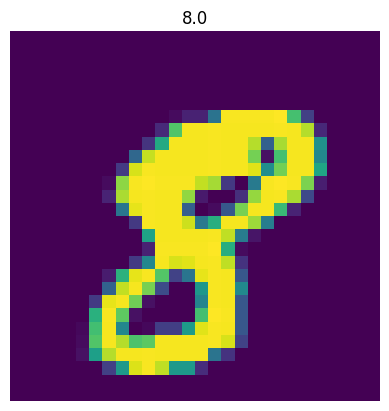

In [14]:
# 准备数据集
# 从 CSV 文件中加载训练数据，数据类型为 float32
train = pd.read_csv(r"./input/train.csv", dtype=np.float32)

# 将数据拆分为特征（像素值）和标签（0-9 的数字）
targets_numpy = train.label.values  # 标签为 0-9 的数字
features_numpy = train.loc[:, train.columns != "label"].values / 255  # 特征值归一化到 0-1 之间

# 将数据拆分为训练集和测试集，80% 为训练集，20% 为测试集
features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42)

# 将训练集中的特征和标签转换为 PyTorch 的 Tensor
featuresTrain = torch.from_numpy(features_train)  # 特征数据
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # 标签数据，数据类型为 long

# 将测试集中的特征和标签转换为 PyTorch 的 Tensor
featuresTest = torch.from_numpy(features_test)  # 特征数据
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # 标签数据，数据类型为 long

# 设置 batch_size，epoch，和迭代次数
batch_size = 100  # 每次训练时处理的样本数量
n_iters = 10000  # 总的迭代次数
num_epochs = n_iters / (len(features_train) / batch_size)  # 计算 epoch 次数
num_epochs = int(num_epochs)

# 创建 PyTorch 数据集和数据加载器
train = TensorDataset(featuresTrain, targetsTrain)  # 训练集
test = TensorDataset(featuresTest, targetsTest)  # 测试集

# 使用 DataLoader 将数据集加载到训练和测试加载器中
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)  # 训练数据加载器
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)  # 测试数据加载器

# 可视化数据集中一张图片
plt.imshow(features_numpy[10].reshape(28, 28))  # 将第 10 张图片重塑为 28x28 的图像
plt.axis("off")  # 去除坐标轴
plt.title(str(targets_numpy[10]))  # 显示对应的标签
plt.savefig('graph.png')  # 保存图片
plt.show()  # 显示图片

In [15]:
# 创建 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # 定义隐藏层的维度
        self.hidden_dim = hidden_dim
        
        # 定义隐藏层的数量
        self.layer_dim = layer_dim
        
        # 定义 RNN 层
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # 定义全连接层，用于输出
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # 初始化隐藏状态为零
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # RNN 前向传播（单步）
        out, hn = self.rnn(x, h0)
        
        # 取最后一个时间步的输出，并通过全连接层
        out = self.fc(out[:, -1, :]) 
        return out

# 设置模型的超参数
input_dim = 28  # 输入的维度（每次输入一行的 28 个像素）
hidden_dim = 100  # 隐藏层维度
layer_dim = 1  # 隐藏层数量
output_dim = 10  # 输出维度（0-9 的数字分类）

# 创建 RNN 模型
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# 定义损失函数，使用交叉熵损失
error = nn.CrossEntropyLoss()

# 使用 SGD 优化器，设置学习率
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
seq_dim = 28  # RNN 每次输入 28 个时间步（对应图片的每一行）

# 初始化一些变量用于存储损失和准确率
loss_list = []  # 存储每次迭代的损失
iteration_list = []  # 存储迭代次数
accuracy_list = []  # 存储每次迭代的准确率
count = 0  # 用于记录迭代次数

# 训练模型
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # 将图片数据转换为 RNN 的输入格式 (batch_size, seq_dim, input_dim)
        train = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        # 清空上一步的梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(train)
        
        # 计算损失
        loss = error(outputs, labels)
        
        # 反向传播计算梯度
        loss.backward()
        
        # 更新模型参数
        optimizer.step()
        
        count += 1
        
        # 每 250 次迭代计算一次准确率
        if count % 250 == 0:
            correct = 0
            total = 0
            
            # 在测试集上计算模型的准确率
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # 前向传播，得到模型预测
                outputs = model(images)
                
                # 取出预测结果中每行最大值对应的索引，即预测的分类
                predicted = torch.max(outputs.data, 1)[1]
                
                # 总的样本数量
                total += labels.size(0)
                
                # 计算预测正确的数量
                correct += (predicted == labels).sum()
            
            # 计算准确率
            accuracy = 100 * correct / float(total)
            
            # 记录损失和准确率
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            # 每 500 次迭代输出一次损失和准确率
            if count % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.item(), accuracy))


Iteration: 500  Loss: 1.6160122156143188  Accuracy: 41.32143020629883 %
Iteration: 1000  Loss: 1.3593705892562866  Accuracy: 65.38095092773438 %
Iteration: 1500  Loss: 0.35298657417297363  Accuracy: 86.02381134033203 %
Iteration: 2000  Loss: 1.2944157123565674  Accuracy: 57.64285659790039 %
Iteration: 2500  Loss: 0.2890228033065796  Accuracy: 85.39286041259766 %
Iteration: 3000  Loss: 0.11710090935230255  Accuracy: 93.38095092773438 %
Iteration: 3500  Loss: 0.2698284387588501  Accuracy: 94.03571319580078 %
Iteration: 4000  Loss: 0.14008654654026031  Accuracy: 94.91666412353516 %
Iteration: 4500  Loss: 0.2709091603755951  Accuracy: 95.45237731933594 %
Iteration: 5000  Loss: 0.057991668581962585  Accuracy: 95.66666412353516 %
Iteration: 5500  Loss: 0.18409320712089539  Accuracy: 95.33333587646484 %
Iteration: 6000  Loss: 0.1554894596338272  Accuracy: 95.26190185546875 %
Iteration: 6500  Loss: 0.0829925611615181  Accuracy: 95.97618865966797 %
Iteration: 7000  Loss: 0.1274832785129547  Acc

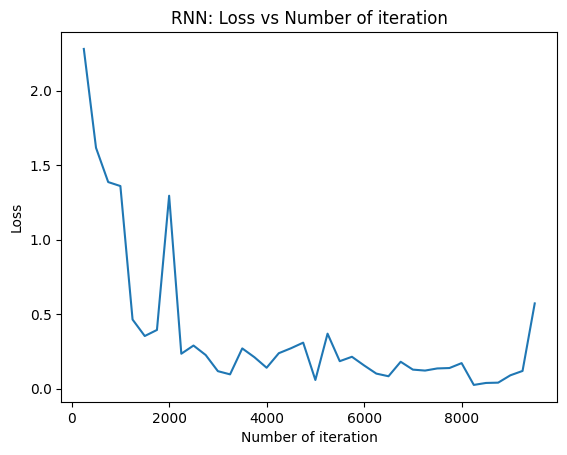

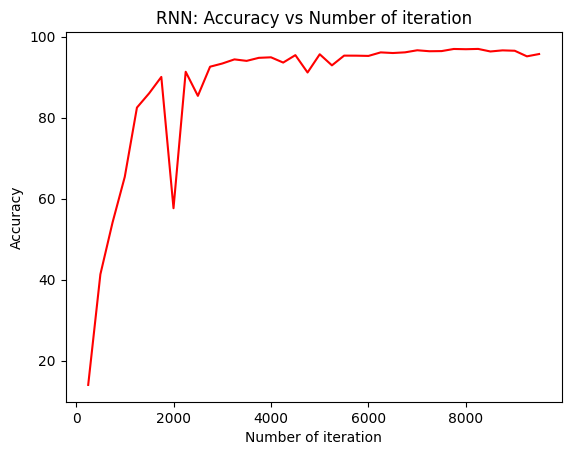

In [17]:
# 可视化损失曲线
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# %%
# 可视化准确率曲线
plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()


In [18]:
# 将模型切换到评估模式
model.eval()

# 禁用梯度计算，因为我们只是在做推理（测试），不需要反向传播
with torch.no_grad():
    correct = 0
    total = 0
    
    # 遍历 test_loader 进行批次预测
    for images, labels in test_loader:
        images = images.view(-1, 28, 28)  # 调整输入形状为 (batch_size, seq_dim, input_dim)
        
        # 前向传播
        outputs = model(images)
        
        # 获取每个样本的最大值索引作为预测结果
        _, predicted = torch.max(outputs.data, 1)
        
        # 更新总样本数和正确预测数
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # 将 Tensor 转换为标量并累加
        
    # 计算准确率
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy} %')


Test Accuracy: 97.04761904761905 %


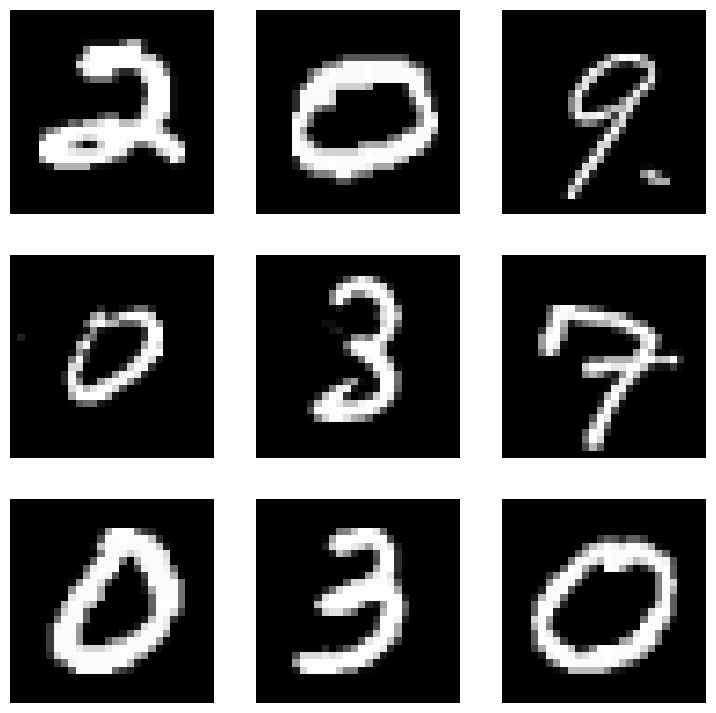

Predicted Labels: [2 0 9 2 3 9 0 3 0]


In [19]:

# 加载 test.csv 数据
test_data = pd.read_csv(r"./input/test.csv", dtype=np.float32)

test_features_numpy = test_data.values / 255  # 归一化特征数据（0-255 -> 0-1）

# 将 test 数据转换为 PyTorch 的 Tensor
test_features = torch.from_numpy(test_features_numpy)

# 创建 DataLoader（此时不需要标签）
test_loader = DataLoader(test_features, batch_size=9, shuffle=False)

# 显示 2x3 网格的 6 张图片
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

# 提取前 6 张图片用于显示和预测
with torch.no_grad():
    images = next(iter(test_loader))  # 从 DataLoader 中获取一批图像
    images = images.view(-1, 28, 28)  # 将图像重塑为 (batch_size, 28, 28)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')  # 显示第 i 张图片
        ax.axis('off')  # 去掉坐标轴

plt.show()  # 显示 6 张图片

# 使用训练好的模型对图片进行预测
# 假设模型已经定义好并训练完毕，处于评估模式
model.eval()

# 禁用梯度计算
with torch.no_grad():
    images = Variable(images.view(-1, 28, 28))  # 转换为 Variable 并调整输入格式 (batch_size, seq_dim, input_dim)
    
    # 前向传播得到预测结果
    outputs = model(images)
    
    # 获取每个样本的最大值索引作为预测结果
    _, predicted = torch.max(outputs.data, 1)

# 4. 打印预测结果
print("Predicted Labels:", predicted.numpy())  # 打印预测标签